In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 1. Specify Pathfile

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# 2. Specify Number of Classes

In [3]:
NUM_CLASSES = 29

# 3. Reading Dataset

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=42)

# 4. Training Model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 128)               5504      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 29)                1885      
                                                                 
Total params: 15,645
Trainable params: 15,645
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=20,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
77/99 [======================>.......] - ETA: 0s - loss: 3.1874 - accuracy: 0.0864
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
99/99 [==============================] - 1s 3ms/step - loss: 3.1301 - accuracy: 0.0973 - val_loss: 2.7774 - val_accuracy: 0.2321
Epoch 2/1000
70/99 [====================>.........] - ETA: 0s - loss: 2.7213 - accuracy: 0.2121
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
99/99 [==============================] - 0s 2ms/step - loss: 2.6545 - accuracy: 0.2251 - val_loss: 2.2546 - val_accuracy: 0.3527
Epoch 3/1000
67/99 [===================>..........] - ETA: 0s - loss: 2.3067 - accuracy: 0.2694
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
99/99 [==============================] - 0s 2ms/step - loss: 2.2295 - accuracy: 0.2928 - val_loss: 1.7715 - val_accuracy: 0.5145
Epoch 4/1000
67/99 [===================>..........] - ETA: 0s - loss: 1.9925 - accuracy: 0.3306
E

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=20)

33/33 [==============================] - 0s 1ms/step - loss: 0.2764 - accuracy: 0.9160


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[3.0133597e-04 1.5269381e-07 5.2278882e-08 5.8170695e-05 2.3302275e-06
 5.5094872e-05 2.2520881e-06 1.8314857e-05 1.7271738e-08 9.6662792e-05
 2.1520468e-07 4.9384062e-06 6.6100351e-05 5.7018021e-08 4.1306356e-07
 4.2379327e-07 1.7098628e-09 2.6779679e-08 1.8618742e-04 1.1232081e-07
 9.9613612e-07 3.9279148e-02 9.5485365e-01 4.9768281e-03 5.2088330e-06
 7.3945078e-10 1.9099349e-05 1.2303238e-05 5.9963626e-05]
22


# 5. Check Trained Model

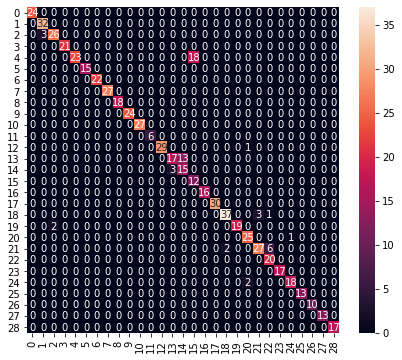

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.91      1.00      0.96        32
           2       0.93      0.90      0.91        29
           3       1.00      1.00      1.00        21
           4       1.00      0.56      0.72        41
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        27
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        24
          10       1.00      1.00      1.00        27
          11       1.00      1.00      1.00         6
          12       1.00      0.97      0.98        30
          13       0.85      0.57      0.68        30
          14       0.54      0.83      0.65        18
          15       0.40      1.00      0.57        12
          16       1.00      1.00      1.00        16
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/fr/jbv693556wl33l33vy0f6c080000gn/T/tmp98pgod57/assets


18280

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 95 µs, sys: 50 µs, total: 145 µs
Wall time: 258 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.5117426e-04 1.1962827e-07 4.5032568e-08 4.8636710e-05 2.1464496e-06
 4.7067500e-05 2.0080302e-06 1.6262324e-05 1.4590852e-08 8.8709843e-05
 1.7880640e-07 4.2917754e-06 5.7678648e-05 5.2031162e-08 3.6755088e-07
 3.7624773e-07 1.5110564e-09 2.3799394e-08 1.5981238e-04 9.6795539e-08
 9.0714065e-07 3.1934936e-02 9.6279949e-01 4.5032166e-03 4.6606870e-06
 6.6067196e-10 1.8061539e-05 1.0608944e-05 4.9143149e-05]
22
